# Placebo test

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import statsmodels.api as sm
from patsy import dmatrices
import pymc as pm
import arviz as az

rng = np.random.default_rng(42)
figsize = (10, 5)
az.style.use("arviz-darkgrid")

In [2]:
filepath = '../../data/processed/df_filtered.xlsx'
df = pd.read_excel(filepath)
df = df.dropna(subset=['population'])

In [15]:
placebo_year_list = [1975, 1980, 1985, 1990, 2000, 2005, 2010]
pre_treatment_data = df[(df['after_treatment'] == 0) & (df['year'] >= 1970) & (df['year'] <= 2015)].copy()

for placebo_year in placebo_year_list:
    pre_treatment_data.loc[(pre_treatment_data['treatment_group'] == 0), f'placebo_treatment_{placebo_year}'] = 0
    pre_treatment_data.loc[(pre_treatment_data['year'] < placebo_year) & (pre_treatment_data['treatment_group'] == 1), f'placebo_treatment_{placebo_year}'] = 0
    pre_treatment_data.loc[(pre_treatment_data['year'] >= placebo_year) & (pre_treatment_data['treatment_group'] == 1), f'placebo_treatment_{placebo_year}'] = 1

df_ = pre_treatment_data.copy()
log_pop_i = df_.groupby('island_ids')['log_pop'].transform('mean')
log_pop_t = df_.groupby('year')['log_pop'].transform('mean')
pre_treatment_data['log_pop_star'] = df_['log_pop'] - log_pop_i - log_pop_t + df_['log_pop'].mean()

In [16]:
mean_t = pre_treatment_data.query('treatment_group == 1').groupby('year')['log_pop'].mean()
mean_c = pre_treatment_data.query('treatment_group == 0').groupby('year')['log_pop'].mean()
std_t = pre_treatment_data.query('treatment_group == 1').groupby('year')['log_pop'].std()
std_c = pre_treatment_data.query('treatment_group == 0').groupby('year')['log_pop'].std()
mean_t_star = pre_treatment_data.query('treatment_group == 1').groupby('year')['log_pop_star'].mean()
mean_c_star = pre_treatment_data.query('treatment_group == 0').groupby('year')['log_pop_star'].mean()
std_t_star= pre_treatment_data.query('treatment_group == 1').groupby('year')['log_pop_star'].std()
std_c_star= pre_treatment_data.query('treatment_group == 0').groupby('year')['log_pop_star'].std()

In [17]:
pre_treatment_data.query('treatment_group == 1').groupby('year')['log_pop'].describe()

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
1970,27.0,7.335608,2.004555,2.484907,6.387848,7.445418,8.695148,10.710387
1975,25.0,7.335308,1.776603,3.828641,6.261492,7.780721,8.591930,10.400316
1980,21.0,6.869982,1.630961,3.951244,5.986452,7.060476,8.141481,9.457903
1985,18.0,6.716511,1.697663,3.663562,5.881856,7.047709,8.014859,8.774158
1990,13.0,7.059433,1.573783,3.737670,6.786717,7.518064,8.170751,8.688454
1995,13.0,6.565073,1.561072,3.496508,6.054439,6.933423,7.742402,8.167636
2000,6.0,6.555583,1.966227,2.772589,6.401174,7.323793,7.617866,8.103797
2001,5.0,6.296896,2.018104,2.833213,6.226537,7.206377,7.515345,7.703008
2002,5.0,6.279418,2.009683,2.833213,6.200509,7.182352,7.491645,7.689371


Text(0.5, 1.0, '平行トレンド')

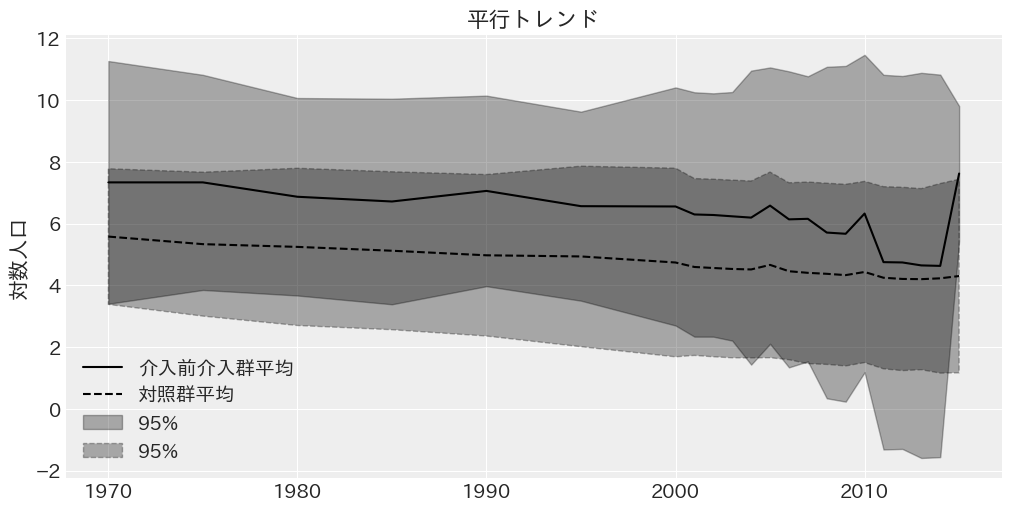

In [18]:
fig, ax = plt.subplots(figsize=figsize)
ax.plot(mean_t, label='介入前介入群平均', color='black')
ax.plot(mean_c, label='対照群平均', color='black', linestyle='dashed')
ax.fill_between(mean_t.index, mean_t - 1.96 * std_t, mean_t + 1.96 * std_t, color='black', alpha=0.3, label='95%')
ax.fill_between(mean_c.index, mean_c - 1.96 * std_c, mean_c + 1.96 * std_c, color='black', linestyle='dashed', alpha=0.3, label='95%')
ax.legend()
ax.set_ylabel('対数人口')
ax.set_title('平行トレンド')

Text(0.5, 1.0, '平行トレンド')

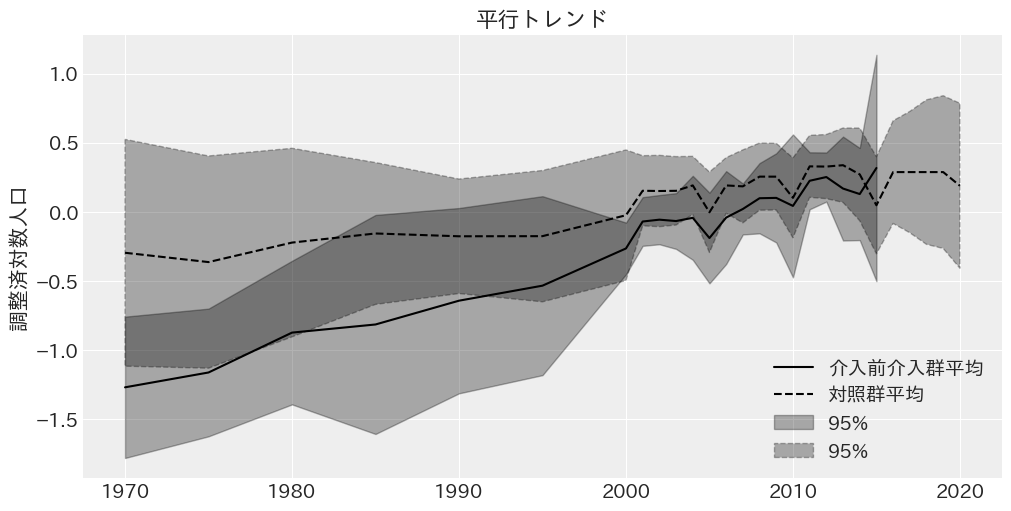

In [54]:
fig, ax = plt.subplots(figsize=figsize)
ax.plot(mean_t_star, label='介入前介入群平均', color='black')
ax.plot(mean_c_star, label='対照群平均', color='black', linestyle='dashed')
ax.fill_between(mean_t_star.index, mean_t_star - 1.96 * std_t_star, mean_t_star + 1.96 * std_t_star, color='black', alpha=0.3, label='95%')
ax.fill_between(mean_c_star.index, mean_c_star - 1.96 * std_c_star, mean_c_star + 1.96 * std_c_star, color='black', linestyle='dashed', alpha=0.3, label='95%')
ax.legend()
ax.set_ylabel('調整済対数人口')
ax.set_title('平行トレンド')

## 頻度主義

In [464]:
placebo_effects = pd.DataFrame()

for placebo_year in placebo_year_list:
    formula = f'log_pop_star ~ placebo_treatment_{placebo_year}'
    y, X = dmatrices(formula, pre_treatment_data, return_type='dataframe')
    freaq_model = sm.OLS(y, X)
    result = freaq_model.fit(cov_type='HC1')
    # print(result.summary())
    summary_df = pd.DataFrame(result.summary().tables[1].data[1:], columns=result.summary().tables[1].data[0])
    summary_df['placebo_year'] = placebo_year
    placebo_effects = pd.concat([placebo_effects, summary_df])

In [465]:
placebo_effects.drop(index=0, inplace=True)

In [466]:
placebo_effects.reset_index(drop=True)
placebo_effects['placebo_year'] = placebo_effects['placebo_year'].astype(str)
placebo_effects.set_index('placebo_year', inplace=True)
placebo_effects.drop(columns=[''], inplace=True)
placebo_effects['coef'] = placebo_effects['coef'].astype(float)
placebo_effects['std err'] = placebo_effects['std err'].astype(float)
placebo_effects['z'] = placebo_effects['z'].astype(float)
placebo_effects['P>|z|'] = placebo_effects['P>|z|'].astype(float)
placebo_effects['[0.025'] = placebo_effects['[0.025'].astype(float)
placebo_effects['0.975]'] = placebo_effects['0.975]'].astype(float)
placebo_effects

,coef,std err,z,P>|z|,[0.025,0.975]
placebo_year,,,,,,
1980,-0.1052,0.028,-3.743,0.000,-0.160,-0.050
1985,-0.0690,0.032,-2.140,0.032,-0.132,-0.006
1990,-0.0151,0.031,-0.492,0.623,-0.075,0.045
1995,0.0119,0.033,0.362,0.718,-0.052,0.076


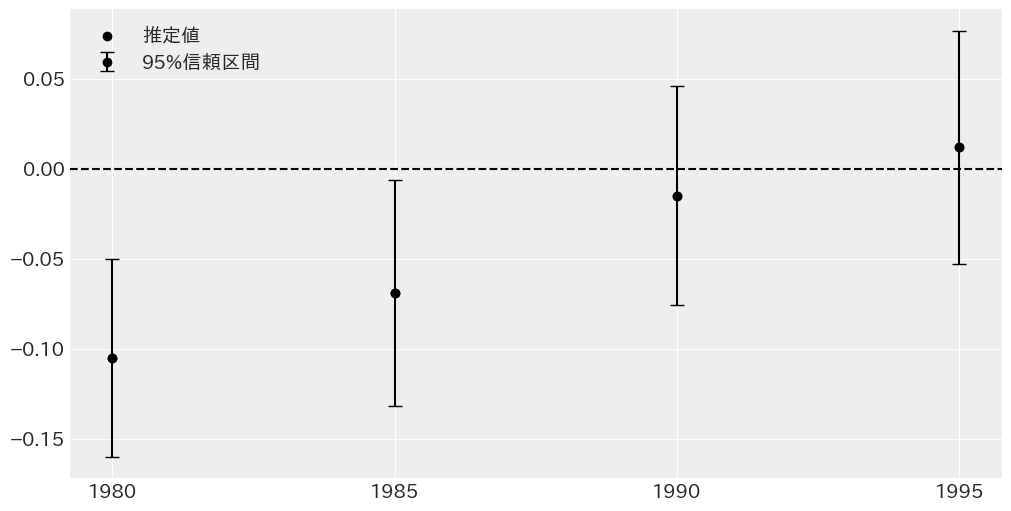

In [467]:
fig, ax = plt.subplots(figsize=figsize)
ax.scatter(placebo_effects.index, placebo_effects['coef'], color='black', label='推定値')
ax.errorbar(
    x=placebo_effects.index,
    y=placebo_effects['coef'],
    yerr=1.96 * placebo_effects['std err'],
    fmt='o',
    color='black',
    capsize=5,
    label='95%信頼区間',
)
ax.legend()
ax.axhline(y=0, color='black', linestyle='--')

# Bayes

In [106]:
island_ids, unique_island_ids = pd.factorize(pre_treatment_data['island_ids'])
n_islands = len(unique_island_ids)

with pm.Model() as model:
    model.add_coords({'obs_id': np.arange(len(pre_treatment_data))})

    # data
    # island_ids = pm.Data('island_ids', island_ids)

    # prior
    beta = pm.Normal('beta', mu=0, sigma=0.1)
    sigma = pm.HalfCauchy('sigma', beta=0.15)
    nu = pm.Gamma('nu', alpha=2, beta=0.1)

    # likelihood
    mu = beta * pre_treatment_data['placebo_treatment']
    y = pm.StudentT('y', mu=mu, sigma=sigma, nu=nu, observed=pre_treatment_data['log_pop_star'], dims='obs_id')

/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/pymc/model/core.py:1302: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


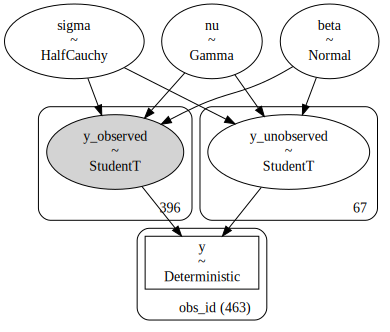

In [107]:
pm.model_to_graphviz(model)

In [108]:
with model:
    trace = pm.sample(
        draws=2000,
        tune=2000,
        chains=4,
        nuts_sampler='numpyro',
        random_seed=rng
    )

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [110]:
az.summary(trace, var_names=['beta', 'sigma', 'nu'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,0.018,0.024,-0.026,0.066,0.000,0.000,15674.0,6321.0,1.0
sigma,0.164,0.012,0.142,0.186,0.000,0.000,5966.0,5508.0,1.0
nu,4.715,1.407,2.580,7.265,0.018,0.013,6194.0,5760.0,1.0


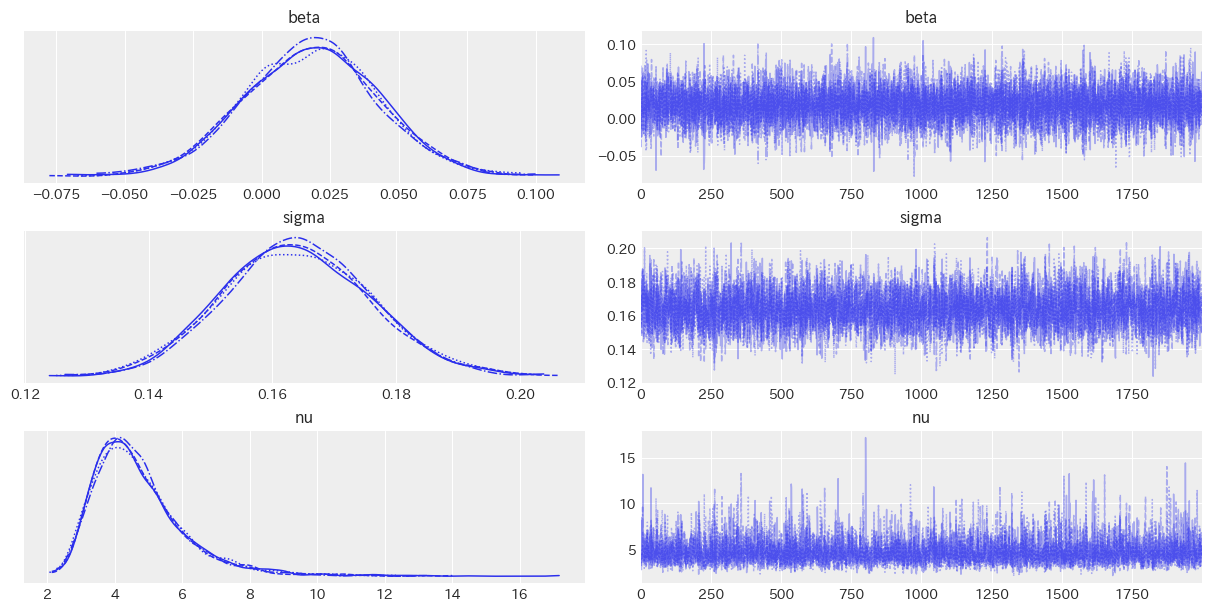

In [112]:
az.plot_trace(trace, var_names=['beta', 'sigma', 'nu']);

<Axes: title={'center': 'beta'}>

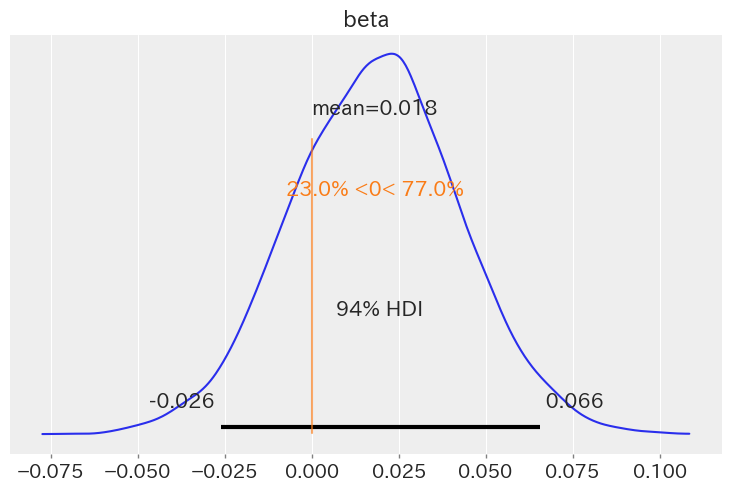

In [114]:
az.plot_posterior(trace, var_names=['beta'], ref_val=0)

In [115]:
with model:
    pm.compute_log_likelihood(trace)

Output()

In [116]:
az.waic(trace)

/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 8000 posterior samples and 396 observations log-likelihood matrix.

          Estimate       SE
elpd_waic    56.97    19.41
p_waic        3.11        -

There has been a warning during the calculation. Please check the results.